# Disable GPU (if needed)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def linear(x):
    return x

## Define build function

In [ ]:
from tensorflow.contrib import slim
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Lambda
import numpy as np

def vgg16_build_func(input_shape=None):
    
    print(input_shape)
    if len(input_shape) == 3:
        input_shape = [1, *input_shape]
    
    # Important - reset graph and session
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    # input_image
    input_image = tf.placeholder(
        tf.float32, shape=input_shape, name='input_image'
    )
    
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                          activation_fn=linear,
                          weights_initializer=tf.constant_initializer(0.001),
                          biases_initializer=tf.constant_initializer(0.0),
                          weights_regularizer=slim.l2_regularizer(0.0005)):
                
        net = slim.repeat(input_image, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        net = slim.avg_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        net = slim.avg_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        net = slim.avg_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        net = slim.avg_pool2d(net, [2, 2], scope='pool4')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
        net = tf.identity(net, name='feature_map')
        net = slim.max_pool2d(net, [2, 2], scope='pool5')
        net = slim.flatten(net, scope='flatten')
        net = slim.fully_connected(net, 4096, scope='fc6')
        net = slim.dropout(net, 0.5, scope='dropout6')
        net = slim.fully_connected(net, 4096, scope='fc7')
        net = slim.dropout(net, 0.5, scope='dropout7')
        net = slim.fully_connected(net, 1000, activation_fn=None, scope='fc8')

    sess.run(tf.global_variables_initializer())
    return net


input_shape = (128, 128, 3)
graph = vgg16_build_func(input_shape=input_shape)
graph

# Tensorflow API

## Load example image

In [4]:
from receptivefield.image import get_default_image

image = get_default_image(shape=(96, 96), tile_factor=1)
image.shape

(288, 288, 3)

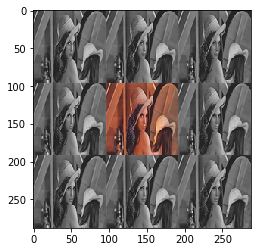

In [5]:
plt.imshow(image)
plt.savefig("../img/demo_tf_lena.jpg", dpi=126)

## Compute RF params for that network

In [ ]:
from receptivefield.tensorflow import TFReceptiveField

rf = TFReceptiveField(vgg16_build_func)

rf_params = rf.compute(
    input_shape=image.shape,
    input_layer='input_image', 
    output_layer='feature_map'
)
rf_params

In [7]:
rf.input_shape

GridShape(n=1, w=288, h=288, c=3)

In [8]:
rf.output_shape

GridShape(n=1, w=18, h=18, c=1)

## Plot example receptive field response

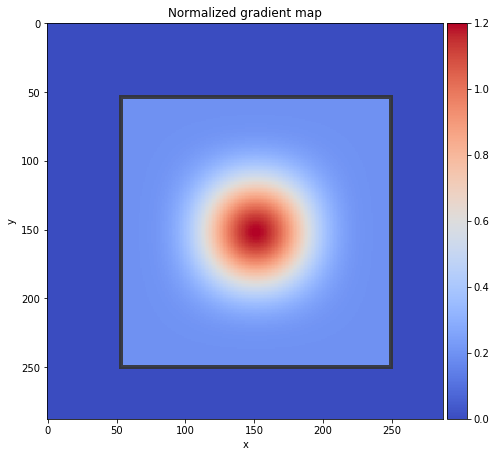

In [9]:
rf.plot_gradient_at((9, 9), image=None, figsize=(7, 7))
plt.savefig("../img/demo_tf_response.jpg", dpi=128)

## Debug receptive field

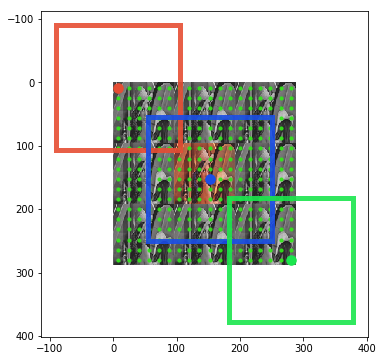

In [10]:
rf.plot_rf_grid(custom_image=image, figsize=(6, 6))
plt.savefig("../img/demo_tf_rf_debug.jpg", dpi=128)

## Same but using subplot

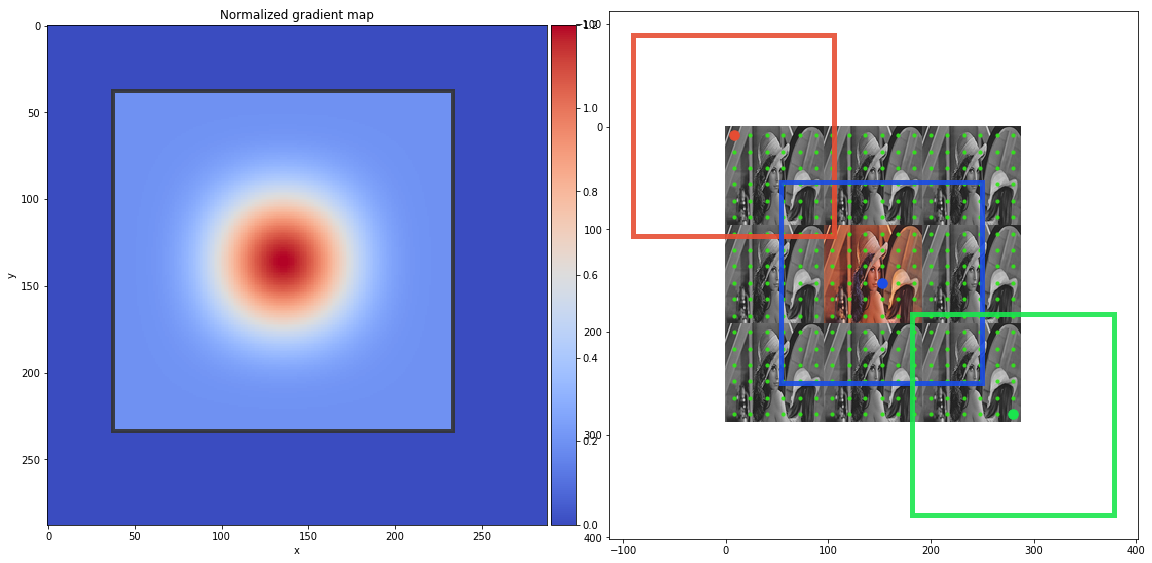

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
rf.plot_gradient_at((8, 8), image=None, axis=ax)
ax = plt.subplot(122)
rf.plot_rf_grid(custom_image=image, axis=ax)